In [3]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки


In [4]:
data = pd.read_csv('data/insurance.csv')
df = data.copy()

In [5]:
def print_metrics(predict, y, dataset_type='тестовых'):
    """
    Выводит значения метрик для предсказанных и реальных значений.

    :param predict: Предсказанные значения
    :param y: Реальные значения
    :param dataset_type: Тип данных ('тестовых' или 'обучающих')
    """
    mae = metrics.mean_absolute_error(y, predict)
    r2 = metrics.r2_score(y, predict)
    mape = metrics.mean_absolute_percentage_error(y, predict) * 100

    print(f"Метрика MAE на {dataset_type} данных: {round(mae)}")
    print(f"Метрика R2 на {dataset_type} данных: {round(r2, 3)}")
    print(f"Метрика MAPE на {dataset_type} данных: {round(mape)}%")
    print()

def outliers_z_score(data, feature, log_scale=False):
    """
    Вычисляет выбросы на основе z-оценки.

    Параметры:
    data (DataFrame): Входные данные.
    feature (str): Название признака для анализа.
    log_scale (bool): Использовать ли логарифмическое масштабирование.

    Возвращает:
    Tuple[DataFrame, DataFrame]: Два фрейма данных: с выбросами и без.
    """
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]

    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma

    out = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]

    return out, cleaned


def plot_numerical_features(df: pd.DataFrame, target: str) -> None:
    """
    Строит гистограммы и диаграммы рассеяния с линейной регрессией
    для всех числовых признаков в DataFrame.

    Параметры:
    df (pd.DataFrame): Входные данные.
    target (str): Название целевого признака для регрессионных диаграмм.

    Возвращает:
    None: Функция выводит графики и не возвращает значения.
    """
    # Извлекаем имена числовых признаков
    num_features = [col for col in df.columns if df[col].dtype != 'object']
    
    # Количество числовых признаков
    n = len(num_features)
    
    # Подготовка фигуры и координатных плоскостей
    fig, axes = plt.subplots(n, 2, figsize=(15, 5 * n))
    
    # Цикл по числовым признакам
    for i, feature in enumerate(num_features):
        # Строим гистограмму распределения признака
        histplot = sns.histplot(data=df, x=feature, ax=axes[i, 0])
        histplot.set_title(f'{feature} hist')
        histplot.xaxis.set_tick_params(rotation=45)
        
        # Строим линейную регрессию
        regplot = sns.regplot(data=df, x=feature, y=target, ax=axes[i, 1])
        regplot.set_title(f'{feature} VS {target}')
        regplot.xaxis.set_tick_params(rotation=45)
    
    # Выравнивание графиков для более удобного отображения
    plt.tight_layout()
    plt.show()

def plot_boxplot(data, title="Boxplot", xlabel="Value", ylabel="Frequency"):
    """
    Строит boxplot для указанной колонки.

    :param data: DataFrame, содержащий данные
    :param title: Заголовок графика
    :param xlabel: Подпись оси X
    :param ylabel: Подпись оси Y
    """
    plt.figure(figsize=(8, 6))
    plt.boxplot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
df.shape

(1338, 7)

In [10]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [11]:
#кодируем бинарные категориальные признаки
df['smoker'] = df['smoker'].apply(lambda x: 0 if x == 'no' else 1)
df['sex'] = df['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
df = pd.get_dummies(df)
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


In [12]:
# plot_numerical_features(df, "charges")

In [13]:
features = df.drop('charges', axis=1).columns
X, y = df[features], df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = X.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [15]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (1070, 9)
X_test: (268, 9)
y_train: (1070,)
y_test: (268,)


In [16]:
lr_model_train = linear_model.LinearRegression()

lr_model_train.fit(X_train, y_train)

LinearRegression()

In [17]:
lr_model_train.intercept_

-12390.804294570285

In [18]:
lr_model_test = linear_model.LinearRegression()

lr_model_test.fit(X_test, y_test)

LinearRegression()

In [19]:
predict_train = lr_model_train.predict(X_train)
predict_test = lr_model_train.predict(X_test)

In [20]:
print_metrics(predict_test, y_test)
print_metrics(predict_train, y_train, dataset_type='обучающих')

Метрика MAE на тестовых данных: 4181
Метрика R2 на тестовых данных: 0.784
Метрика MAPE на тестовых данных: 47%

Метрика MAE на обучающих данных: 4208
Метрика R2 на обучающих данных: 0.742
Метрика MAPE на обучающих данных: 42%



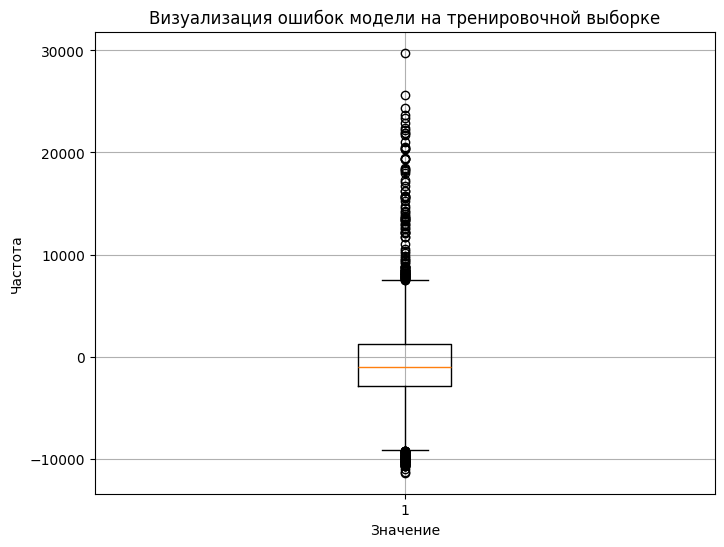

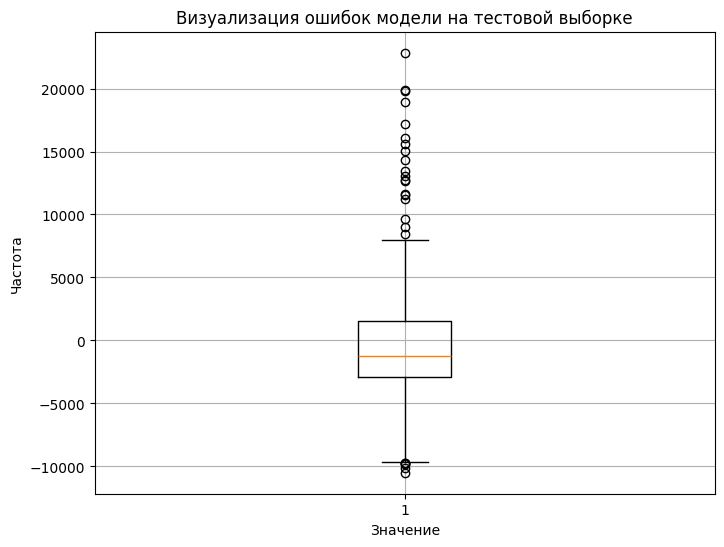

In [21]:
difference_true_train = y_train - predict_train
difference_true_test = y_test - predict_test

plot_boxplot(difference_true_train, "Визуализация ошибок модели на тренировочной выборке", "Значение", "Частота")

plot_boxplot(difference_true_test, "Визуализация ошибок модели на тестовой выборке", "Значение", "Частота")

In [42]:
# Получаем имена столбцов из датафрейма X_train
col_names = X_train.columns

# Создаем объект MinMaxScaler из библиотеки sklearn для нормализации данных
mm_scaler = preprocessing.MinMaxScaler()

mm_scaler.fit(X_train)

# Применяем MinMaxScaler к тренировочным данным для масштабирования значений в диапазоне от 0 до 1
df_mm_train = mm_scaler.transform(X_train)

# Применяем MinMaxScaler к тестовым данным для масштабирования значений в том же диапазоне от 0 до 1
df_mm_test = mm_scaler.transform(X_test)

# Преобразуем нормализованные данные обратно в DataFrame с использованием исходных имен столбцов
df_mm_train = pd.DataFrame(df_mm_train, columns=col_names)
df_mm_test = pd.DataFrame(df_mm_test, columns=col_names)

# Отображаем статистическое описание нормализованных тренировочных данных
display(df_mm_train.describe())

# Отображаем статистическое описание нормализованных тестовых данных
display(df_mm_test.describe())

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,0.464283,0.512150,0.392801,0.221495,0.205607,0.249533,0.239252,0.264486,0.246729
std,0.305956,0.500086,0.162588,0.243197,0.404334,0.432945,0.426827,0.441265,0.431309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.000000,0.275626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.467391,1.000000,0.383374,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.717391,1.000000,0.498688,0.400000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,0.448005,0.477612,0.406635,0.208955,0.201493,0.212687,0.257463,0.302239,0.227612
std,0.303561,0.500433,0.169681,0.232705,0.401866,0.409973,0.438054,0.460087,0.420075
min,0.000000,0.000000,0.023002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.000000,0.288169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.434783,0.000000,0.398709,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.695652,1.000000,0.517622,0.400000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,0.985203,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
df_mm_train['age'].sum()

496.78260869565224

In [43]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(df_mm_train)

#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(df_mm_train)
X_test_poly = poly.transform(df_mm_test)


#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)


(1070, 54)
(268, 54)


In [44]:
X_test_poly_df = pd.DataFrame(X_test_poly)

sum_of_feats = []

for n in range(X_test_poly_df.shape[1]):
    sum_of_feats.append(X_test_poly_df.iloc[n].sum())

In [41]:
sum_of_feats

[5.466047119646791,
 3.954955172937247,
 10.205516875668874,
 10.835007620871359,
 10.964342838537654,
 9.993556462335716,
 2.3915628476653046,
 11.7064562310056,
 2.5116674626797177,
 11.569549704762451,
 14.103917985684431,
 9.960439919282184,
 4.022096803916881,
 19.159090561359534,
 17.251382823891824,
 17.42598908942563,
 7.777590903065,
 10.483980505462196,
 5.130627560506748,
 8.002781933200222,
 10.493635900574937,
 10.438454481816024,
 6.35774816634418,
 3.936186301178595,
 6.994267702228278,
 5.6088036157396886,
 6.4104212085942684,
 5.313156599412701,
 5.7744450003321575,
 6.256521959982769,
 7.074113144683355,
 5.785783130356682,
 3.432104055886663,
 4.564768326976532,
 7.60649010662653,
 9.824310165291553,
 3.2666322634106177,
 5.0686049516383225,
 9.399032181292638,
 14.261005030957536,
 6.169967785266801,
 7.426814318243796,
 6.827913768069361,
 9.467356964741551,
 9.828018141905208,
 10.598153129392553,
 4.500846143729644,
 4.598591085043413,
 17.596955394024114,
 9.986

In [45]:
# Создаем экземпляр линейной регрессии
mm_liner_model = linear_model.LinearRegression()

# Обучаем модель на полиномиальных признаках тренировочных данных
mm_liner_model.fit(X_train_poly, y_train)

# Предсказываем значения на тестовых данных с использованием обученной модели
predict_test = mm_liner_model.predict(X_test_poly)

# Выводим метрики качества модели на тестовых данных
print_metrics(predict_test, y_test)

Метрика MAE на тестовых данных: 2738
Метрика R2 на тестовых данных: 0.866
Метрика MAPE на тестовых данных: 30%



In [46]:
print('w0: {}'.format(mm_liner_model.intercept_)) #свободный член w0

w0: 7.561671848335146e+16


In [47]:
# Инициализация модели линейной регрессии с Lasso регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)

# Обучение модели на тренировочных данных
lasso_lr_poly.fit(X_train_poly, y_train)

# Предсказание на тестовых данных
predict_test_lasso = lasso_lr_poly.predict(X_test_poly)

# Вывод метрик для оценки качества модели
print_metrics(predict_test_lasso, y_test)

Метрика MAE на тестовых данных: 2719
Метрика R2 на тестовых данных: 0.867
Метрика MAPE на тестовых данных: 30%



In [48]:
print('w0: {}'.format(lasso_lr_poly.intercept_)) #свободный член w0

w0: 2249.7135241035703


In [49]:
# Инициализация модели линейной регрессии с Ridge регуляризацией
ridge_lr_poly = linear_model.Ridge()

# Обучаем Ridge-регрессию на тренировочных данных
ridge_lr_poly.fit(X_train_poly, y_train)

# Используем обученную модель для предсказания значений на тестовых данных
predict_test_ridge = ridge_lr_poly.predict(X_test_poly)

# Выводим метрики, чтобы оценить качество модели на тестовых данных
print_metrics(predict_test_ridge, y_test)


"""
НЕ ПРАВИЛЬНО
задание 6.9
"""

Метрика MAE на тестовых данных: 2861
Метрика R2 на тестовых данных: 0.863
Метрика MAPE на тестовых данных: 31%



'\nНЕ ПРАВИЛЬНО\nзадание 6.9\n'

In [29]:
print('w0: {}'.format(ridge_lr_poly.intercept_)) #свободный член w0

w0: 2450.975763224169
